# How to do mesh-valued regression?

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import (
    IndexMap,
    ListSqueeze,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading meshes

In [3]:
prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: DictMap(PvAlign(**kwargs)),
    _target=lambda meshes: meshes[list(meshes.keys())[0]],
    max_iterations=500,
)

In [4]:
subject_id = "01"

file_finder = DenseMaternalMeshLoader(
    subject_id=subject_id,
    as_dict=True,
    left=True,
    struct="Hipp",
)

pipe = file_finder + DictMap(PvReader()) + prep_pipe

meshes = pipe()

## Loading tabular data

In [5]:
pilot = subject_id == "01"

pipe = DenseMaternalCsvDataLoader(pilot=pilot, subject_id=subject_id)

df = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/maternal/28Baby_Hormones.csv').


Here, we filter the tabular data.

In [6]:
session_selector = ppd.DfIsInFilter("stage", ["post"], negate=True)

predictor_selector = (
    session_selector + ppd.ColumnsSelector("gestWeek") + ppd.SeriesToDict()
)

In [7]:
x_dict = predictor_selector(df)

## Create and fit regressor

Follow [How to perform dimensionality reduction on a mesh?](./mesh_dim_reduction.ipynb), we create a pipeline to transform the output variable.

In [8]:
pca = PCA(n_components=4)

objs2y = AdapterPipeline(
    steps=[
        FunctionTransformer(func=np.squeeze),  # undo sklearn 2d
        FunctionTransformer(inverse_func=ListSqueeze(raise_=False)),
        BiMeshesToVertices(index=0),
        FunctionTransformer(func=np.stack),
        BiFlattenButFirst(),
        StandardScaler(with_std=False),
        pca,
    ],
)

Tip: `polpo.models.Meshes2FlatVertices` is syntax sugar for the code above.

We get the data in the proper format for fitting and instantiate a regressor model.

In [9]:
dataset_pipe = (
    DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)
)

X, meshes_ = dataset_pipe((x_dict, meshes))

X.shape, len(meshes_)

((19, 1), 19)

In [10]:
model = ObjectRegressor(LinearRegression(fit_intercept=True), objs2y=objs2y)

In [11]:
model.fit(X, meshes_)

ObjectRegressor(objs2y=AdapterPipeline(steps=[('step_0',
                                               FunctionTransformer(func=<function squeeze at 0x709fa89a7d70>)),
                                              ('step_1',
                                               FunctionTransformer(inverse_func=<polpo.preprocessing._preprocessing.ListSqueeze object at 0x709e4c127590>)),
                                              ('step_2', BiMeshesToVertices()),
                                              ('step_3',
                                               FunctionTransformer(func=<function stack at 0x709fa89afaf0>)),
                                              ('step_4', BiFlattenButFirst()),
                                              ('step_5',
                                               StandardScaler(with_std=False)),
                                              ('step_6', PCA(n_components=4))]))

## Evaluate fit

`model.predict` outputs meshes, but we know `LinearRegression` sees `PCA` components. We can evaluate [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) by applying transform.

NB: these are values on the training data.

Tip: `objs2y` is available in `model.objs2y`.

In [12]:
meshes_pred = model.predict(X)

y_true = objs2y.transform(meshes_)
y_pred = objs2y.transform(meshes_pred)

r2_score(y_true, y_pred, multioutput="raw_values")

array([0.04356303, 0.00644151, 0.2458346 , 0.00145251])

This shows the model performs poorly. (NB: the goal of this notebook is not to find a great model, but to show how the analysis can be performed. Adapting the pipeline to use different models is a no-brainer.)

The analysis can also be done at a mesh level. The following assumes Euclidean distance.

In [13]:
meshes2vertices = Map(ToVertices()) + np.stack + FlattenButFirst()

In [14]:
meshes2vertices = Map(ToVertices()) + np.stack + FlattenButFirst()

r2_score(
    meshes2vertices(meshes_),
    meshes2vertices(meshes_pred),
    multioutput="uniform_average",
)

0.0484419375334223

## Visualize predictions

In [15]:
X_pred = np.linspace(-3, 42, num=10)[:, None]

meshes_pred = model.predict(X_pred)

In [16]:
outputs_dir = Path("_images")
if not outputs_dir.exists():
    outputs_dir.mkdir()

gif_name = outputs_dir / "regression.gif"

pl = pv.Plotter(
    border=False,
    off_screen=True,
    notebook=False,
)

pl.open_gif(gif_name.as_posix(), fps=3)

rendered_mesh = meshes_pred[0].copy()
pl.add_mesh(rendered_mesh, show_edges=True)
pl.add_title(f"{(X_pred[0][0]):.0f}")
pl.write_frame()

for index, mesh in enumerate(meshes_pred[1:]):
    rendered_mesh.points = mesh.points
    pl.render()

    pl.add_title(f"{(X_pred[index+1][0]):.0f}")

    pl.write_frame()


pl.close()

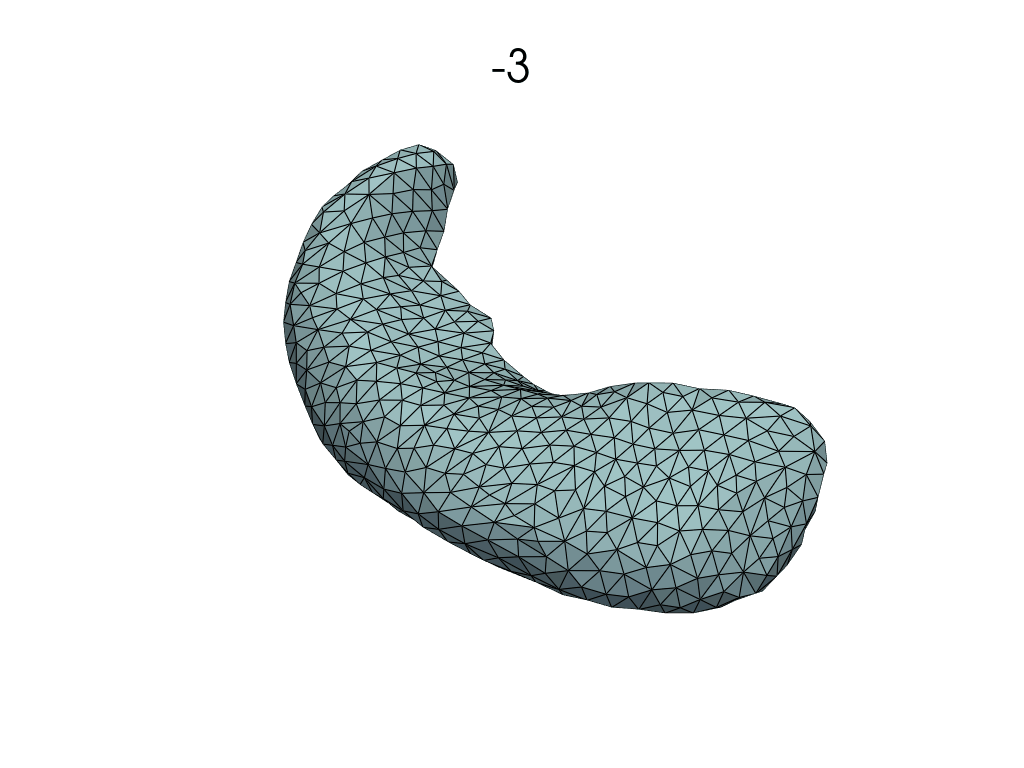

In [17]:
Image(open(gif_name, "rb").read())

Let's check the predicted volumes.

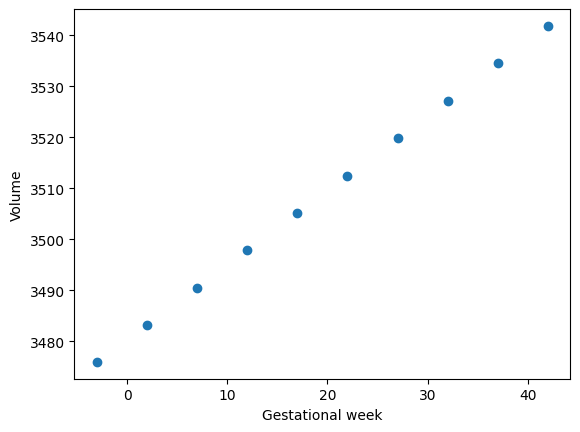

In [18]:
volumes = [mesh.volume for mesh in meshes_pred]

plt.scatter(X_pred, volumes)
plt.xlabel("Gestational week")
plt.ylabel("Volume");